# Import

In [1]:
import bz2
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from torch.utils.data import Dataset, DataLoader
import uuid

import nltk
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader, random_split
# import torchtext
import collections

import sys
sys.path.append('../')
import contractions
import re

import bz2

# Pretrained bert

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn.utils.rnn as rnn_utils

# NLTK package
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

#The essentials
print('stopwords = ', STOPWORDS)

stopwords =  {'she', 'mustn', "won't", 'this', 'have', 'which', 'down', "should've", 'you', "mightn't", 'more', 'and', 'do', "doesn't", 'themselves', 'all', "it's", 'the', 'that', 'from', 'again', 't', 'into', 'about', 'then', 'shouldn', 'is', 'didn', 'did', 'y', "didn't", 'below', 's', 'in', "shan't", 'does', 'hasn', 'with', 'out', "wouldn't", 'up', 'but', 'hers', 'a', 'not', "needn't", 'we', 'very', 'o', "couldn't", 'theirs', 'too', 've', "wasn't", "hasn't", "she's", 'above', 'only', 'your', 'ourselves', 'no', 'whom', 'some', 'how', 'when', "hadn't", 'are', 'on', 'each', 'over', 'same', "don't", 'aren', "you'd", 'as', 'where', 'at', "that'll", 'ours', 'yours', 'has', 'weren', "aren't", 'other', 'd', 'before', 'he', 'why', 'those', 'being', 'or', 'mightn', 'these', 'don', 'such', "weren't", 'doing', 'to', 'few', 're', 'ain', 'its', 'their', 'further', 'between', "mustn't", "you'll", 'once', 'haven', 'nor', 'by', 'yourself', 'there', 'itself', 'both', 'them', 'i', 'wouldn', 'myself', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Constants 

In [ ]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_review', 'train.ft.txt.bz2')
sample_train_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'sample_train.csv')
sample_test_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'sample_val.csv')

train_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'train.csv')
test_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'test.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

BATCH_SIZE = 32

# Load the whole dataset and truncate it (for experiments)

In [3]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

train_txt = bz2.BZ2File(DATASET_PATH)
train_lines = train_txt.readlines()

In [4]:
for line in train_lines[:5]:
    print(line)

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'
b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"
b'__label__2 Amazing!: This sou

# Sample size

In [58]:
#only tkae 10% of this dataset
LIMIT = int(1 * len(train_lines))
print('limit = ', LIMIT)

truncated_train_lines = train_lines[:LIMIT]

TRAIN_RATIO = 0.9
train_len = int(len(truncated_train_lines) * TRAIN_RATIO)

train_array = [x.decode('utf-8') for x in truncated_train_lines[:train_len]]
test_array = [x.decode('utf-8') for x in truncated_train_lines[train_len:]]

#apply limit to a big dataset
train_array = train_array[:LIMIT]

print('train len = ', len(train_array))
print('test len = ', len(test_array))

limit =  3600000
train len =  3240000
test len =  360000


# Clean text

In [59]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'test string special characters punctuations _'

In [61]:
def convert_to_df(array):
    X_array = []
    y_array = []
    cleaned_X_array = []

    for line in tqdm(array):
        parts = line.split(' ')
        label = parts[0]
        feature = ' '.join(parts[1:])

        # X_array.append(feature)
        X_array.append(clean_text(feature))
        y_array.append( 0 if label == '__label__1' else 1)


    # df = pd.DataFrame({'target':y_array, 'text':X_array, 'clean_text': cleaned_X_array})
    df = pd.DataFrame({'target':y_array, 'clean_text': X_array})
    return df

train_df = convert_to_df(train_array)
test_df = convert_to_df(test_array)
train_df.to_csv(sample_train_df_path, index=False)
test_df.to_csv(sample_test_df_path, index=False)

print('train df = ', train_df.shape)
print('test df = ', test_df.shape)
print('train df label counts ')
print(train_df['target'].value_counts())
print('test df label counts ')
print(test_df['target'].value_counts())


  0%|          | 825/3240000 [00:00<06:33, 8235.24it/s]

100%|██████████| 360000/360000 [00:27<00:00, 13003.69it/s]


train df =  (3240000, 2)
test df =  (360000, 2)
train df label counts 
target
1    1622321
0    1617679
Name: count, dtype: int64
test df label counts 
target
0    182321
1    177679
Name: count, dtype: int64


# Loading the sample_dataset

In [45]:
train_df = pd.read_csv(sample_train_df_path)
train_df.drop('text', axis = 1)
test_df = pd.read_csv(sample_test_df_path)
test_df.drop('text', axis = 1)

,target,clean_text
0,0,bottom barrel actioner summary two l cops dolp...
1,0,worth collect brandon lee work essential may w...
2,0,real happy product come time well packed scrat...
3,0,sure break heart warning people adults kids bu...
4,0,outdated non essential get following le orme a...
...,...,...
3595,1,tiny mighty well built used alot already great...
3596,1,perfect tweezers bought tweezer two years ago ...
3597,0,last long uses already weak worth buying get o...
3598,0,happy tool comes wtih plastic case helps carry...


# Train and test df shape check

In [48]:
print(train_df.shape)
train_df.head()

(32400, 3)


,target,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even non gamer sound track beautiful p...
1,1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything reading lot revi...
2,1,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...


In [47]:
print(test_df.shape)
test_df.head()

(3600, 3)


,target,text,clean_text
0,0,Bottom of the Barrel Actioner: Summary: Two L....,bottom barrel actioner summary two l cops dolp...
1,0,For what it's worth....: If you're out to coll...,worth collect brandon lee work essential may w...
2,0,"Not real happy: Product come on time, and was ...",real happy product come time well packed scrat...
3,0,Sure To Break Your Heart: This is a warning to...,sure break heart warning people adults kids bu...
4,0,Outdated and non-essential: Get the following ...,outdated non essential get following le orme a...


# A little EDA

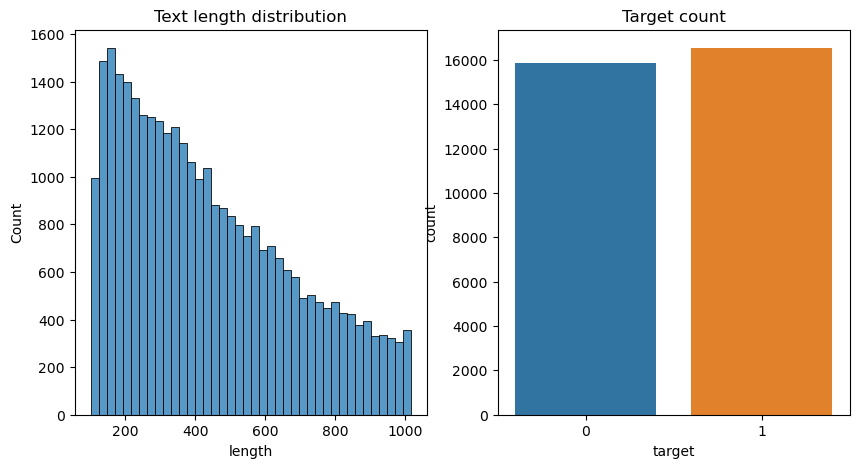

In [49]:
train_df['length'] = train_df['text'].apply(lambda s: len(s))
#plot 2, hist of length
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(train_df, x = 'length', ax = ax1)
ax1.set_title("Text length distribution")
sns.countplot(train_df, x = 'target', ax = ax2)
ax2.set_title("Target count")
plt.show()